In [1]:
import gym
import numpy as np
import time 
import matplotlib.pyplot as plt

In [2]:
env = gym.make('CartPole-v0')
print(env.action_space) #[Output: ] Discrete(2)
print(env.observation_space) # [Output: ] Box(4,)

Discrete(2)
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [3]:
# returns an initial observation
env.reset()

for i in range(10):

  # env.action_space.sample() produces either 0 (left) or 1 (right).
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)

  print("step", i, ":", action, observation, reward, done, info)
  if done:
    print("Finished after {} timesteps".format(i+1))
    break

env.close()

step 0 : 0 [-0.0330686  -0.212516   -0.00590192  0.26180434] 1.0 False {}
step 1 : 1 [-0.03731892 -0.0173103  -0.00066583 -0.03273427] 1.0 False {}
step 2 : 1 [-0.03766512  0.1778212  -0.00132052 -0.3256272 ] 1.0 False {}
step 3 : 1 [-0.0341087   0.37296194 -0.00783306 -0.61872625] 1.0 False {}
step 4 : 0 [-0.02664946  0.17795026 -0.02020759 -0.32852063] 1.0 False {}
step 5 : 0 [-0.02309046 -0.01687827 -0.026778   -0.04227813] 1.0 False {}
step 6 : 1 [-0.02342802  0.17861722 -0.02762356 -0.34328803] 1.0 False {}
step 7 : 0 [-0.01985568 -0.01610107 -0.03448932 -0.05944232] 1.0 False {}
step 8 : 0 [-0.0201777  -0.21071197 -0.03567817  0.22216259] 1.0 False {}
step 9 : 0 [-0.02439194 -0.40530628 -0.03123492  0.50338113] 1.0 False {}


In [4]:
def Qtable(state_space,action_space,bin_size = 30):
    
    bins = [np.linspace(-4.8,4.8,bin_size),
            np.linspace(-4,4,bin_size),
            np.linspace(-0.418,0.418,bin_size),
            np.linspace(-4,4,bin_size)]
    
    q_table = np.zeros(([bin_size] * state_space + [action_space]))
    #q_table = np.random.uniform(low=-1,high=1,size=([bin_size] * state_space + [action_space]))
    
    return q_table, bins

In [5]:
bin_size = 30
Q, bins = Qtable(4,2,bin_size)
Q.shape

(30, 30, 30, 30, 2)

In [6]:
def Discrete(state, bins):
    index = []
    for i in range(len(state)): index.append(np.digitize(state[i],bins[i]) - 1)
    return tuple(index)

In [7]:
test_state = env.reset()
test_state_discrete = Discrete(test_state, bins)
print(test_state)
print(test_state_discrete)

[-0.02698686  0.03440372  0.00073141 -0.03226525]
(14, 14, 14, 14)


In [8]:
def Q_learning(q_table, bins, episodes, gamma, lr, timestep, start_epsilon):
    
    runs = [0]  # list of cumulative reward per episode
    data = {'max' : [0], 'avg' : [0], 'epsilon' : [start_epsilon]}
    rewards = 0
    steps = 0
    solved = False

    for episode in range(1,episodes+1):
        ep_start = time.time()
        steps += 1 

        epsilon_list = np.linspace(start_epsilon, 0, episodes)  # make epsilon decay to 0 linearly
        epsilon = epsilon_list[episode-1]

        current_state = Discrete(env.reset(),bins)

        score = 0
        done = False
        while not done:
            if episode % timestep==0: env.render()
            if np.random.uniform(0,1) < epsilon:  # if random number is less than epsilon, choose random action
                    action = env.action_space.sample()
            else: # otherwise choose max reward action
                action = np.argmax(q_table[current_state])

            observation, reward, done, __ = env.step(action)  # take chosen action
            new_state = Discrete(observation,bins)
            score += reward  #???????
            
            if not done:
                max_future_q = np.max(q_table[new_state])  # best estimated reward at current state
                current_q = q_table[current_state+(action,)]
                new_q = (1-lr)*current_q + lr*(reward + gamma*max_future_q)
                q_table[current_state+(action,)] = new_q

            current_state = new_state
            
        # End of the loop update
        else:
            rewards += score
            runs.append(score)

            if score > 195 and steps >= 100 and solved == False:
                solved = True
                print('First solved in episode : {} in time {}'.format(episode, (time.time()-ep_start)))
        
        # Timestep value update
        if episode % timestep == 0:
            print('Episode : {} | Avg. reward -> {} | Max reward : {} | Epsilon : {} | Time : {}'.format(episode, rewards/timestep, max(runs), epsilon, time.time() - ep_start))
            data['max'].append(max(runs))
            data['avg'].append(rewards/timestep)
            data['epsilon'].append(epsilon)

            rewards, runs= 0, [0]

    env.close()

    return q_table, data

In [9]:
# define parameters
episodes = 1000
gamma = 0.9
lr = 0.1
timestep = 100
start_epsilon = 0.3

# run Q learning
q_final, data = Q_learning(Q, bins, episodes, gamma, lr, timestep, start_epsilon)

Episode : 100 | Avg. reward -> 29.12 | Max reward : 80.0 | Epsilon : 0.2702702702702703 | Time : 0.5346150398254395
Episode : 200 | Avg. reward -> 36.61 | Max reward : 75.0 | Epsilon : 0.24024024024024024 | Time : 0.5759925842285156
Episode : 300 | Avg. reward -> 36.4 | Max reward : 88.0 | Epsilon : 0.2102102102102102 | Time : 1.0065231323242188
Episode : 400 | Avg. reward -> 43.98 | Max reward : 120.0 | Epsilon : 0.18018018018018017 | Time : 1.64556884765625
Episode : 500 | Avg. reward -> 58.84 | Max reward : 195.0 | Epsilon : 0.15015015015015015 | Time : 1.3718948364257812
Episode : 600 | Avg. reward -> 56.29 | Max reward : 159.0 | Epsilon : 0.1201201201201201 | Time : 0.7372612953186035
First solved in episode : 639 in time 0.012997150421142578
Episode : 700 | Avg. reward -> 64.68 | Max reward : 200.0 | Epsilon : 0.09009009009009009 | Time : 0.7111372947692871
Episode : 800 | Avg. reward -> 59.65 | Max reward : 173.0 | Epsilon : 0.060060060060060066 | Time : 0.6651220321655273
Episo

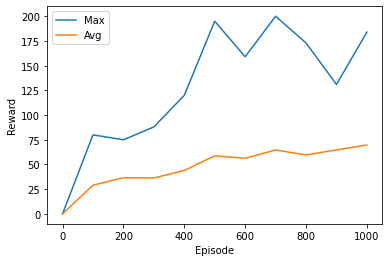

In [12]:
# plot epsilons
ep = [i for i in range(0, episodes + 1, timestep)] 
plt.plot(ep, data['max'], label = 'Max')
plt.plot(ep, data['avg'], label = 'Avg')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend(loc = "upper left")
plt.show()

(0.0, 1.0)

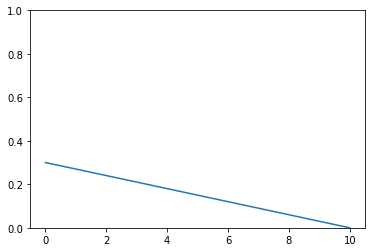

In [17]:
# plot epsilon decay
plt.plot(range(len(data['epsilon'])), data['epsilon'], label = 'Epsilon')
plt.ylim(0, 1)